In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
df = pd.read_csv('perrin-freres-monthly-champagne.csv')
df.rename(columns={"Perrin Freres monthly champagne sales millions ?64-?72": "Sales"},inplace=True)

In [3]:
df.isnull().sum()


Month    1
Sales    2
dtype: int64

In [4]:
df = df.replace(r'^\s*$', np.nan, regex=True)
pd.to_numeric(df.Sales, errors="ignore")

0      2815.0
1      2672.0
2      2755.0
3      2721.0
4      2946.0
        ...  
102    4298.0
103    1413.0
104    5877.0
105       NaN
106       NaN
Name: Sales, Length: 107, dtype: float64

In [5]:
df.dropna(inplace=True)

In [6]:
pd.to_numeric(df.Sales, errors="ignore")

0      2815.0
1      2672.0
2      2755.0
3      2721.0
4      2946.0
        ...  
100    4618.0
101    5312.0
102    4298.0
103    1413.0
104    5877.0
Name: Sales, Length: 105, dtype: float64

In [7]:
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')
df.set_index('Month', inplace=True)

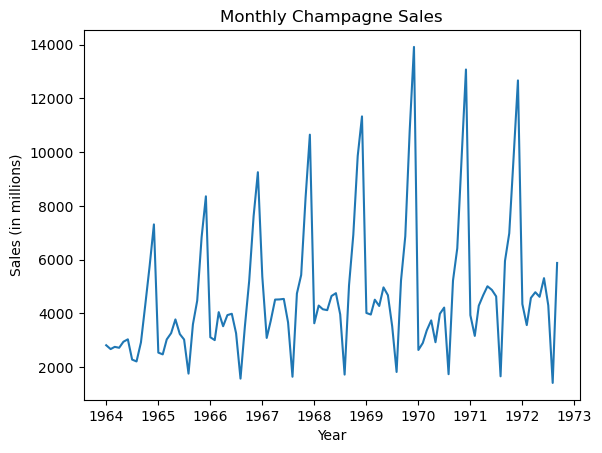

In [8]:
plt.plot(df)
plt.title("Monthly Champagne Sales")
plt.xlabel("Year")
plt.ylabel("Sales (in millions)")
plt.show()

In [9]:
result = adfuller(df['Sales'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:")
for key, value in result[4].items():
    print("\t", key, value)

ADF Statistic: -1.8335930563276195
p-value: 0.3639157716602467
Critical Values:
	 1% -3.502704609582561
	 5% -2.8931578098779522
	 10% -2.583636712914788


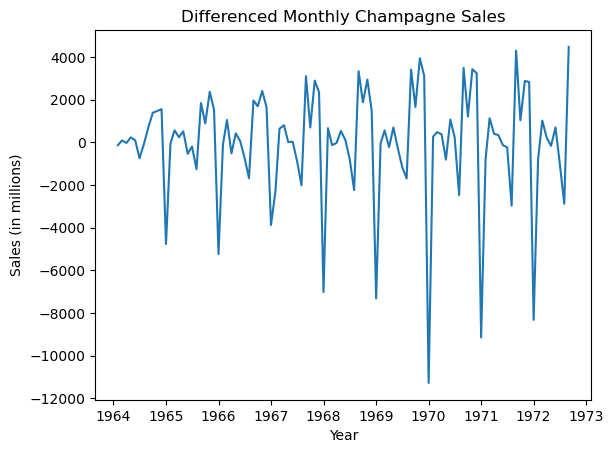

In [10]:
df_diff = df.diff().dropna()
plt.plot(df_diff)
plt.title("Differenced Monthly Champagne Sales")
plt.xlabel("Year")
plt.ylabel("Sales (in millions)")
plt.show()

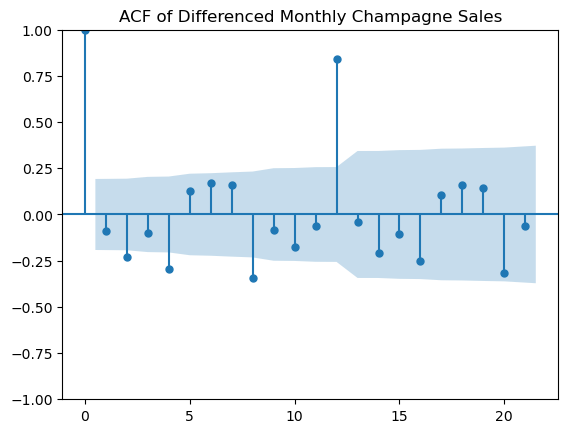

C:\Users\SV\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


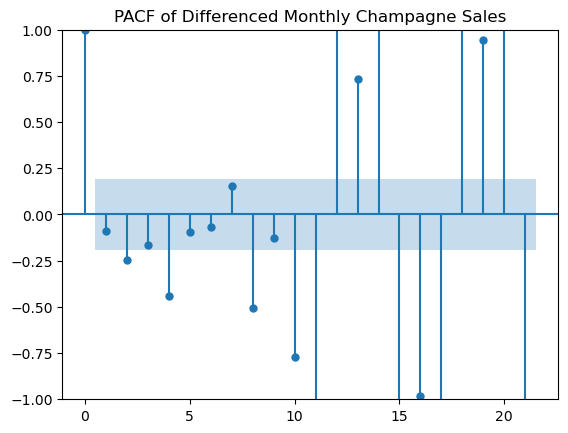

In [11]:
# Plot the autocorrelation and partial autocorrelation graphs to identify the appropriate ARIMA model
plot_acf(df_diff)
plt.title("ACF of Differenced Monthly Champagne Sales")
plt.show()
plot_pacf(df_diff)
plt.title("PACF of Differenced Monthly Champagne Sales")
plt.show()


In [12]:
# Fit the ARIMA model to the data
model = ARIMA(df, order=(1,1,1))
model_fit = model.fit()

C:\Users\SV\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\SV\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\SV\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


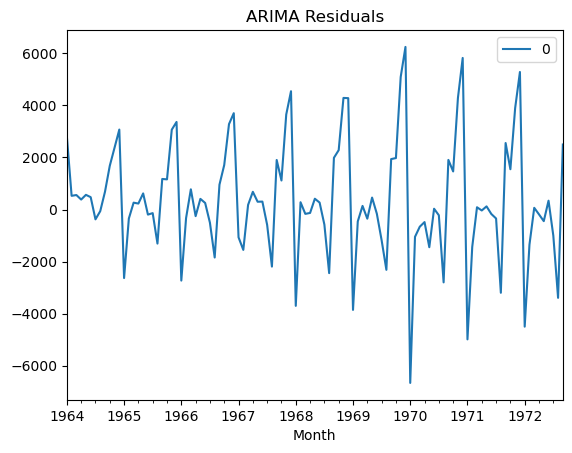

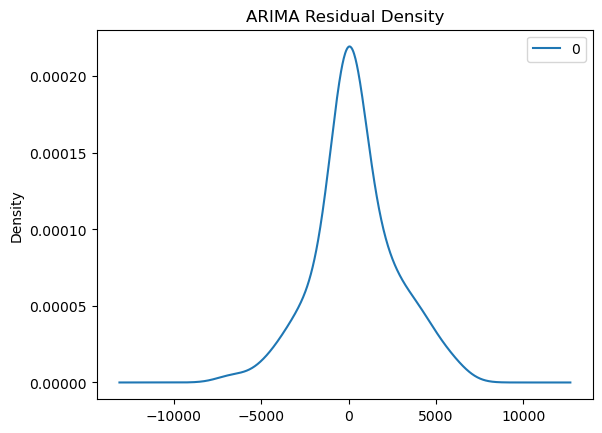

                 0
count   105.000000
mean    385.484259
std    2276.288602
min   -6658.585461
25%    -506.381156
50%     229.401001
75%    1678.821643
max    6244.318360


In [13]:
# Do residual diagnostics to check if the residuals are white noise
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.title("ARIMA Residuals")
plt.show()
residuals.plot(kind='kde')
plt.title("ARIMA Residual Density")
plt.show()
print(residuals.describe())

<function matplotlib.pyplot.show(close=None, block=None)>

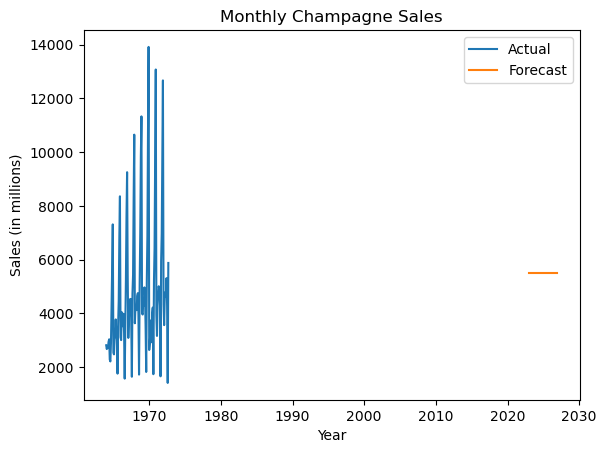

In [14]:
# Forecast the next four years using the ARIMA model
forecast = model_fit.forecast(steps=48)
forecast_df = pd.DataFrame(forecast[0], index=pd.date_range(start='1/1/2023', periods=48, freq='MS'), columns=['Sales'])
plt.plot(df, label='Actual')
plt.plot(forecast_df, label='Forecast')
plt.title("Monthly Champagne Sales")
plt.xlabel("Year")
plt.ylabel("Sales (in millions)")
plt.legend()
plt.show

In [15]:
# Identify the appropriate ETS model using the AIC criterion
model = ExponentialSmoothing(df, trend='add', seasonal='add', seasonal_periods=12)
model_fit = model.fit()
print(model_fit.summary())


                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Sales   No. Observations:                  105
Model:             ExponentialSmoothing   SSE                       49978732.332
Optimized:                         True   AIC                           1404.681
Trend:                         Additive   BIC                           1447.144
Seasonal:                      Additive   AICC                          1412.634
Seasonal Periods:                    12   Date:                 Fri, 28 Apr 2023
Box-Cox:                          False   Time:                         14:38:32
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0727910                alpha                 True
smoothing_trend          

C:\Users\SV\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


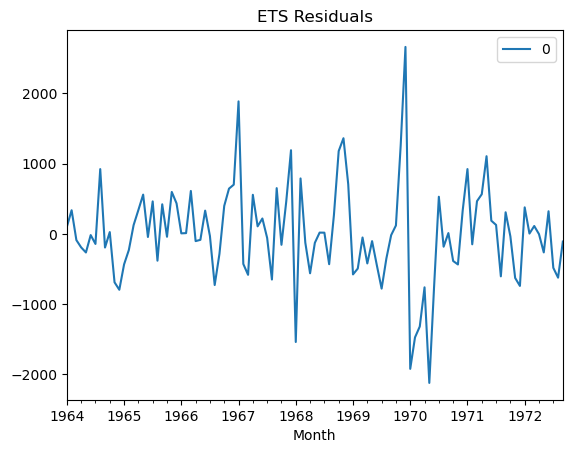

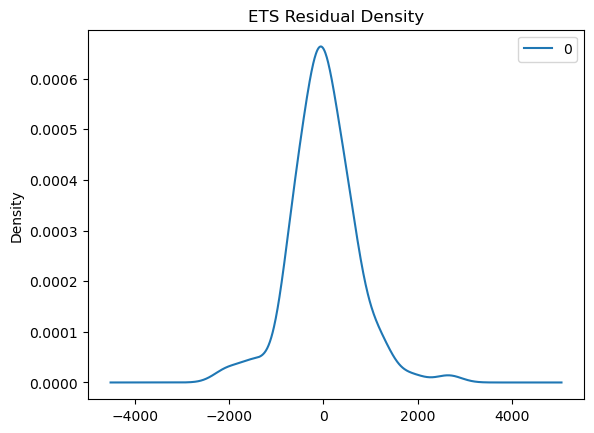

                 0
count   105.000000
mean      1.705634
std     693.225646
min   -2122.741207
25%    -421.288565
50%     -30.664491
75%     377.378398
max    2662.072247


In [16]:
# Do residual diagnostics to check if the residuals are white noise
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.title("ETS Residuals")
plt.show()
residuals.plot(kind='kde')
plt.title("ETS Residual Density")
plt.show()
print(residuals.describe())

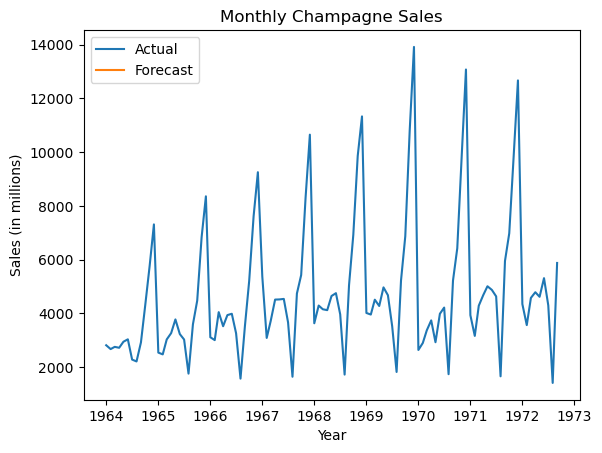

In [17]:
# Forecast the next four years using the ETS model
forecast = model_fit.forecast(steps=48)
forecast_df = pd.DataFrame(forecast, index=pd.date_range(start='1/1/2023', periods=48, freq='MS'), columns=['Sales'])
plt.plot(df, label='Actual')
plt.plot(forecast_df, label='Forecast')
plt.title("Monthly Champagne Sales")
plt.xlabel("Year")
plt.ylabel("Sales (in millions)")
plt.legend()
plt.show()